In [1]:
import pickle
from ML_Dataset_Preparation import *
from ML_Model_Master import *

pickle_in = open("PN4_Data_600DS.pickle","rb")
ml_data = pickle.load(pickle_in)

Using TensorFlow backend.


In [5]:
#Training in series
activation = 'relu'
neurons = 128
dropout_rate = 0.2
learn_rate = [1e-3,1e-4]
decay = 1e-5
batch_size = [10,20]
epochs = 5

models_series = []
for lr in learn_rate:
    for bs in batch_size:
        ml_model = ML_Model_Builder(activation,neurons,dropout_rate,lr,decay,bs,epochs)
        ml_model._train_model(ml_data)
        models_series.append(ml_model)

Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate = 0.2
Learning Rate = 0.001
Decay = 1e-05
Epochs=5
Batch Size=10
Train on 775 samples, validate on 518 samples
Epoch 1/5
775/775 [==============================] - 2s 3ms/step - loss: 0.1091 - rmse: 0.2826 - val_loss: 0.0955 - val_rmse: 0.2512
Epoch 2/5
775/775 [==============================] - 1s 2ms/step - loss: 0.0724 - rmse: 0.2067 - val_loss: 0.0747 - val_rmse: 0.2231
Epoch 3/5
775/775 [==============================] - 1s 2ms/step - loss: 0.0570 - rmse: 0.1916 - val_loss: 0.0534 - val_rmse: 0.1797
Epoch 4/5
775/775 [==============================] - 1s 2ms/step - loss: 0.0433 - rmse: 0.1523 - val_loss: 0.0408 - val_rmse: 0.1382
Epoch 5/5
775/775 [==============================] - 1s 2ms/step - loss: 0.0363 - rmse: 0.1268 - val_loss: 0.0386 - val_rmse: 0.1263
Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate 

In [6]:
#Parallel Attempts:
from multiprocessing import Pool
from itertools import repeat

activation = 'relu'
neurons = 128
dropout_rate = 0.2
learn_rate = [1e-3,1e-4]
decay = 1e-5
batch_size = [10,20]
epochs = 5

models_parallel = []
for lr in learn_rate:
    for bs in batch_size:
        ml_model = ML_Model_Builder(activation,neurons,dropout_rate,lr,decay,bs,epochs)
        models_parallel.append(ml_model)

def fit_function(ml_model,ml_data):
    ml_model._train_model(ml_data)
    
if __name__ == '__main__':
    p = Pool(5)
    result = p.starmap(fit_function, zip(models_parallel,repeat(ml_data)))


Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate = 0.2
Learning Rate = 0.001
Decay = 1e-05
Epochs=5
Batch Size=10
Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate = 0.2
Learning Rate = 0.0001
Decay = 1e-05
Epochs=5
Batch Size=10Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate = 0.2
Learning Rate = 0.0001
Decay = 1e-05
Epochs=5
Batch Size=20

Training Model with Parameters:
Downsampling = 600
Lag Periods = 3
Activation = relu
Neurons = 128
Dropout Rate = 0.2
Learning Rate = 0.001
Decay = 1e-05
Epochs=5
Batch Size=20


Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/uufs/chpc.utah.edu/common/ho

KeyboardInterrupt: 

In [7]:
error_name  = 'rmse'   

error_vals = []
for m in models:
    error_vals.append(m.history.history[error_name][-1])
best_idx = error_vals.index(min(error_vals))

print(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}")
print(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
Lag Periods: {models[best_idx].periods_to_lag}\n\
Activation: {models[best_idx].activation}\n\
Neurons: {models[best_idx].neurons}\n\
Learning Rate: {models[best_idx].learn_rate}\n\
Decay: {models[best_idx].decay}\n\
Epochs: {models[best_idx].epochs}")

Best score for 'rmse' was 0.12452015280723572 in model 0
Downsampling Seconds: 600
Lag Periods: 3
Activation: relu
Neurons: 128
Learning Rate: 0.001
Decay: 1e-05
Epochs: 5


Fitting data from X_test


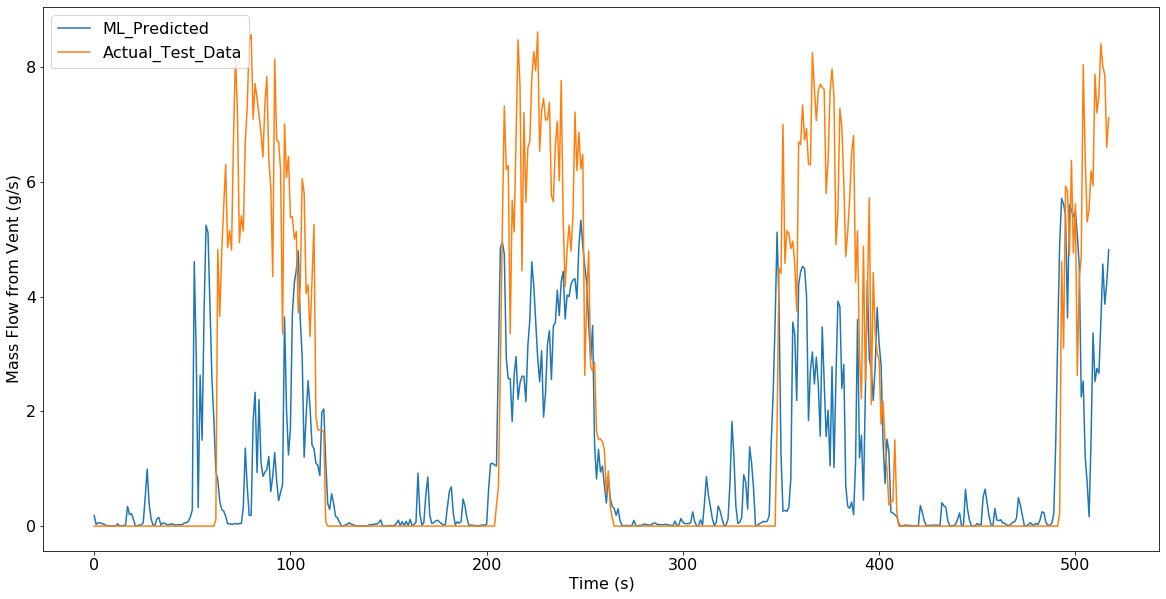

In [8]:
import matplotlib.pyplot as plt

i=best_idx

models[i]._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()